# HALO-(AC)³ HALO-SMART quicklooks


In [1]:
# import modules and set paths
import os
import xarray as xr
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)  # change standard figure size
plt.rcParams["font.size"] = 16  # change standard text size in figures
import numpy as np
import pandas as pd
data_path = "C:/Users/Johannes/Documents/Doktor/conferences_workshops/2022_02_HALO-AC3_hackathon/data/RF09_20200205/"
halo_smart_path = f"{data_path}/halo-smart"
halo_smart_file = "EUREC4A_HALO_SMART_spectral_irradiances_20200205_R3.nc"
halo_smart_filepath = os.path.join(halo_smart_path, halo_smart_file)
bahamas_path = f"{data_path}/bahamas"
bahamas_file = "EUREC4A_HALO_BAHAMAS-QL-10Hz_20200205a.nc"
bahamas_file_path = os.path.join(bahamas_path, bahamas_file)

In [2]:
# define some convenience functions
def read_bahamas(bahamas_path: str) -> xr.Dataset:
    """
    Reader function for netcdf BAHAMAS data as provided by DLR.

    Args:
        bahamas_path: full path of netcdf file

    Returns: xr.DataSet with BAHAMAS data and time as dimension

    """
    ds = xr.open_dataset(bahamas_path)
    ds = ds.swap_dims({"tid": "TIME"})
    ds = ds.rename({"TIME": "time"})

    return ds

Read in data from campaign storage

In [3]:
ds_halo_smart = xr.open_dataset(halo_smart_filepath)
ds_halo_smart

<xarray.Dataset>
Dimensions:               (time: 32730)
Coordinates:
  * time                  (time) datetime64[ns] 2020-02-05T09:15:53 ... 2020-...
Data variables:
    alt                   (time) float32 ...
    lat                   (time) float32 ...
    lon                   (time) float32 ...
    sza                   (time) float32 ...
    saa                   (time) float32 ...
    F_down_solar_wl_422   (time) float32 ...
    F_down_solar_wl_532   (time) float32 ...
    F_down_solar_wl_648   (time) float32 ...
    F_down_solar_wl_858   (time) float32 ...
    F_down_solar_wl_1238  (time) float32 ...
    F_down_solar_wl_1638  (time) float32 ...
Attributes:
    Title:                Spectral downward irradiance measured by SMART duri...
    campaign:             EUREC4A
    platform:             HALO
    Research_Flight_Day:  2020/20/05
    Version:              Revision 3 from 2021/01/24
    comment 1:            BAHAMAS data was processed by DLR, contact Andreas ...
    Contact:              Andre Ehrlich, University Leipzig, a.ehrlich@uni-le...

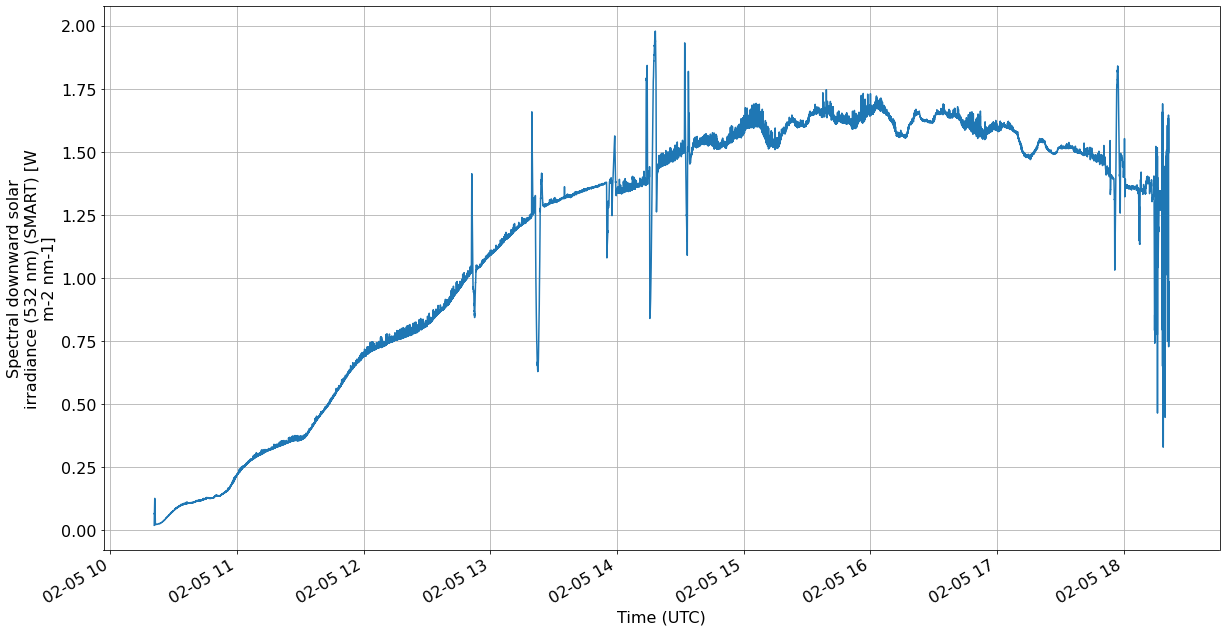

In [4]:
ds_halo_smart.F_down_solar_wl_532.plot()
plt.grid()
plt.xlabel("Time (UTC)")
plt.show()
plt.close()

In [5]:
ds_halo_smart.F_down_solar_bb.plot()
plt.grid()
plt.xlabel("Time (UTC)")
plt.show()
plt.close()

AttributeError: 'Dataset' object has no attribute 'F_down_solar_bb'

In [6]:
# read in BAHAMAS data
ds_bahamas = read_bahamas(bahamas_file_path)
ds_bahamas

<xarray.Dataset>
Dimensions:    (time: 327320)
Coordinates:
  * time       (time) datetime64[ns] 2020-02-05T09:15:52 ... 2020-02-05T18:21...
Data variables: (12/45)
    IGI_RMSX   (time) float32 ...
    IGI_RMSY   (time) float32 ...
    IGI_RMSZ   (time) float32 ...
    IRS_ALT    (time) float32 ...
    IRS_ATA    (time) float32 ...
    IRS_AXB    (time) float32 ...
    ...         ...
    TS         (time) float32 ...
    RELHUM     (time) float32 ...
    SOURCE     (time) float32 ...
    WS         (time) float32 ...
    MIXRATIOV  (time) float32 ...
    MIXRATIO   (time) float32 ...
Attributes: (12/19)
    title:                Quality controlled data of DLR measurment flight ad...
    aircraft:             D-ADLR
    project:              EUREC4A
    mission:              EUREC4A
    ProjectInvestigator:  Stevens
    flightname:           adlr_20200205a
    ...                   ...
    date_last_revised:    2020-2-6
    TimeInterval:         09:15:52 - 18:21:24
    comment:               Humidity is measured with SHARC and/or HUMICAP VAI...
    platform:             HALO
    instrument:           BAHAMAS
    Variablelist:          TIME IGI_RMSX IGI_RMSY IGI_RMSZ IRS_ALT IRS_ATA IR...

SMART and BAHAMAS both have a very high time resolution.
Let's resample SMART data to 1 second resolution and then select BAHAMAS time steps which are closest to HALO-SMART time steps.
This will take a few moments...

In [7]:
ds_halo_smart = ds_halo_smart.resample(time="1s").mean()
ds_bahamas = ds_bahamas.sel(time=ds_halo_smart.time, method="nearest")
ds_bahamas

<xarray.Dataset>
Dimensions:    (time: 32730)
Coordinates:
  * time       (time) datetime64[ns] 2020-02-05T09:15:53 ... 2020-02-05T18:21:22
Data variables: (12/45)
    IGI_RMSX   (time) float32 ...
    IGI_RMSY   (time) float32 ...
    IGI_RMSZ   (time) float32 ...
    IRS_ALT    (time) float32 ...
    IRS_ATA    (time) float32 ...
    IRS_AXB    (time) float32 ...
    ...         ...
    TS         (time) float32 ...
    RELHUM     (time) float32 ...
    SOURCE     (time) float32 ...
    WS         (time) float32 ...
    MIXRATIOV  (time) float32 ...
    MIXRATIO   (time) float32 ...
Attributes: (12/19)
    title:                Quality controlled data of DLR measurment flight ad...
    aircraft:             D-ADLR
    project:              EUREC4A
    mission:              EUREC4A
    ProjectInvestigator:  Stevens
    flightname:           adlr_20200205a
    ...                   ...
    date_last_revised:    2020-2-6
    TimeInterval:         09:15:52 - 18:21:24
    comment:               Humidity is measured with SHARC and/or HUMICAP VAI...
    platform:             HALO
    instrument:           BAHAMAS
    Variablelist:          TIME IGI_RMSX IGI_RMSY IGI_RMSZ IRS_ALT IRS_ATA IR...

Use the BAHAMAS pitch and roll data to filter out high attitude angles from the data

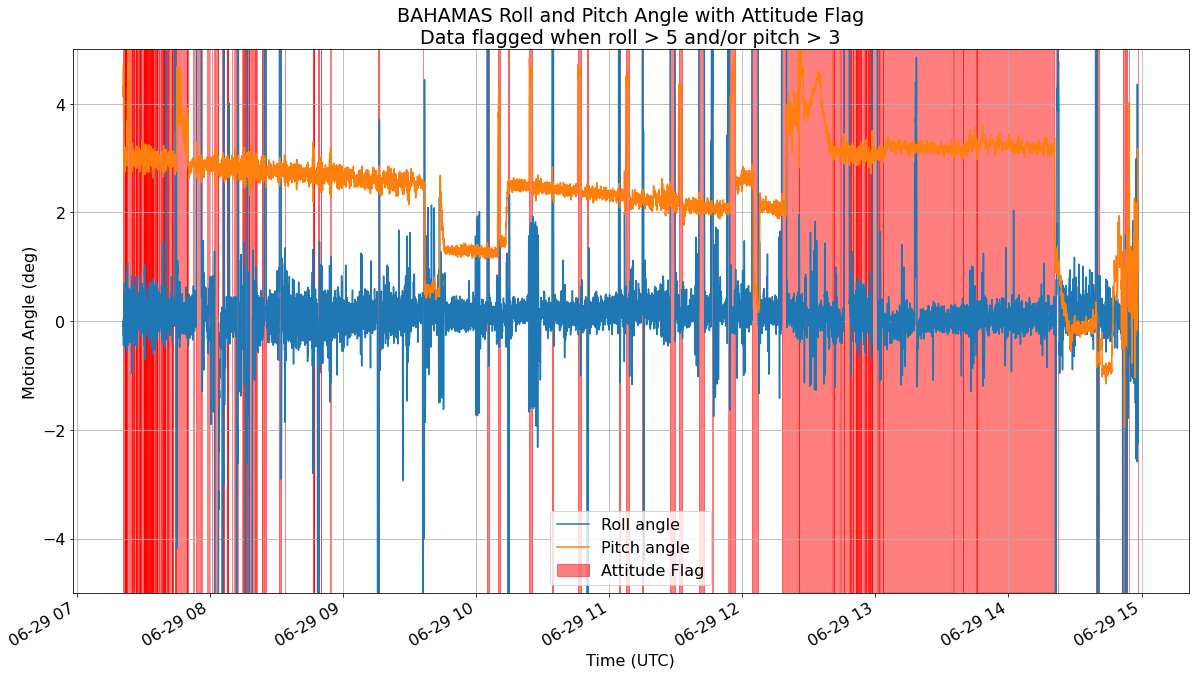

In [9]:
roll_filter = 5
pitch_filter = 3
attitude_filter = ((np.abs(ds_bahamas.IRS_PHI) < roll_filter) & (np.abs(ds_bahamas.IRS_THE) < pitch_filter)).values
# plot result together with motion angles
fig, ax = plt.subplots()
ds_bahamas.IRS_PHI.plot(ax=ax, label="Roll angle")
ds_bahamas.IRS_THE.plot(ax=ax, label="Pitch angle")
ax.fill_between(ds_bahamas.time.values, 0, 1, where=~attitude_filter, transform=ax.get_xaxis_transform(), label="Attitude Flag", color="red", alpha=0.5)
ax.set_ylim(-5, 5)
ax.grid()
ax.legend()
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Motion Angle (deg)")
ax.set_title(f"BAHAMAS Roll and Pitch Angle with Attitude Flag\nData flagged when roll > {roll_filter} and/or pitch > {pitch_filter}")
plt.show()
plt.close()

Plot HALO-SMART data with attitude flag

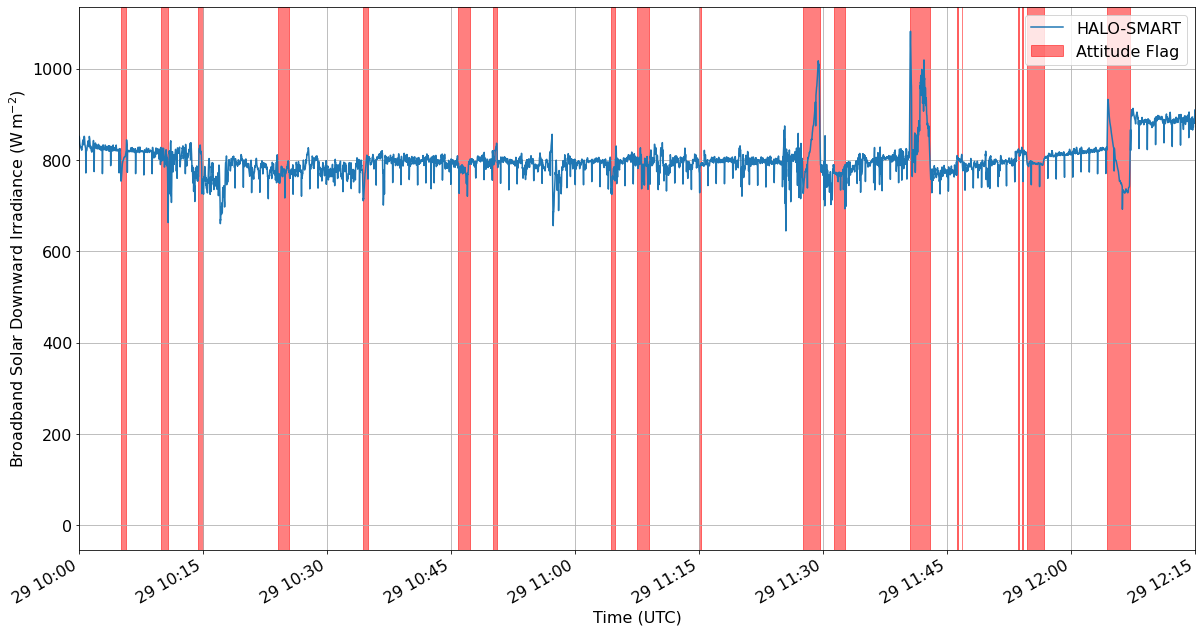

In [10]:
x_sel = (pd.Timestamp(2021, 6, 29, 10), pd.Timestamp(2021, 6, 29, 12, 15))  # select only parts of the flight
fig, ax = plt.subplots()
ds_halo_smart.F_down_solar_bb.plot(ax=ax, label="HALO-SMART")
ax.fill_between(ds_halo_smart.time.values, 0, 1, where=~attitude_filter, transform=ax.get_xaxis_transform(), label="Attitude Flag", color="red", alpha=0.5)
ax.set_xlim(x_sel)
ax.grid()
ax.legend()
ax.set_xlabel("Time (UTC)")
ax.set_ylabel("Broadband Solar Downward Irradiance (W$\,$m$^{-2}$)")
plt.show()
plt.close()

Filter out the data and derive statistics

In [11]:
ds_halo_smart_filtered = ds_halo_smart.where(attitude_filter)
ds_halo_smart_filtered

<xarray.Dataset>
Dimensions:               (time: 27582)
Coordinates:
  * time                  (time) datetime64[ns] 2021-06-29T07:21:00 ... 2021-...
Data variables:
    F_down_solar_wl_422   (time) float64 nan nan nan nan nan ... nan nan nan nan
    F_down_solar_wl_532   (time) float64 nan nan nan nan nan ... nan nan nan nan
    F_down_solar_wl_648   (time) float64 nan nan nan nan nan ... nan nan nan nan
    F_down_solar_wl_858   (time) float64 nan nan nan nan nan ... nan nan nan nan
    F_down_solar_wl_1238  (time) float64 nan nan nan nan nan ... nan nan nan nan
    F_down_solar_wl_1638  (time) float64 nan nan nan nan nan ... nan nan nan nan
    F_down_solar_bb       (time) float64 nan nan nan nan nan ... nan nan nan nan

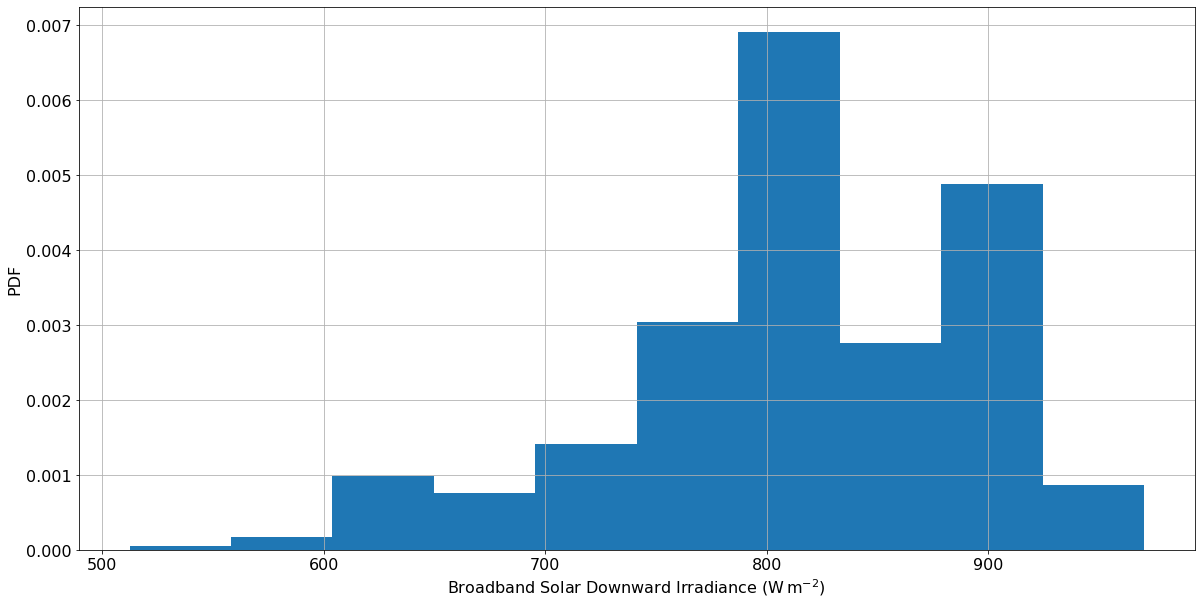

In [16]:
ds_halo_smart_filtered.F_down_solar_bb.plot.hist(density=True)
plt.grid()
plt.xlabel("Broadband Solar Downward Irradiance (W$\,$m$^{-2}$)")
plt.ylabel("PDF")
plt.show()
plt.close()